## 1. Data Preparations

### 1.1 Download dataset
To get the Kaggle dataset we mount Google Drive, where Kaggle creds are stored, and use the Kaggle library to download data.

In [2]:
competition_name = "airbus-ship-detection"

# Mount your Google Drive
from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/drive/MyDrive/kaggle.json"

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c {competition_name}

! mkdir kaggle_data
! unzip {competition_name + ".zip"} -d kaggle_data

# Unmount your Google Drive
drive.flush_and_unmount()

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: kaggle_data/train_v2/b83d9dca6.jpg  
  inflating: kaggle_data/train_v2/b83df81e4.jpg  
  inflating: kaggle_data/train_v2/b83e983b6.jpg  
  inflating: kaggle_data/train_v2/b83ec97d1.jpg  
  inflating: kaggle_data/train_v2/b83f3690e.jpg  
  inflating: kaggle_data/train_v2/b83f8637f.jpg  
  inflating: kaggle_data/train_v2/b83fa2f21.jpg  
  inflating: kaggle_data/train_v2/b83fa9b38.jpg  
  inflating: kaggle_data/train_v2/b83fc1419.jpg  
  inflating: kaggle_data/train_v2/b8401bd29.jpg  
  inflating: kaggle_data/train_v2/b840272b9.jpg  
  inflating: kaggle_data/train_v2/b84029e1d.jpg  
  inflating: kaggle_data/train_v2/b8402d7b3.jpg  
  inflating: kaggle_data/train_v2/b8403f24b.jpg  
  inflating: kaggle_data/train_v2/b8409c081.jpg  
  inflating: kaggle_data/train_v2/b8418ba51.jpg  
  inflating: kaggle_data/train_v2/b841c69ed.jpg  
  inflating: kaggle_data/train_v2/b84213c1b.jpg  
  inflating: kaggle_data/train_v

### 1.2 Install & Import libraries

In [3]:
# For local use

#!pip install --user numpy
#!pip install pandas
#!python -m pip install -U matplotlib
#!python -m pip install -U scikit-image
#!pip install -U scikit-learn
#!pip install keras
#!pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
import tensorflow

### 1.3 List data

In [2]:
BASE_DIR = 'kaggle_data'
TRAIN_DIR = BASE_DIR + '/train_v2/'
TEST_DIR = BASE_DIR + '/test_v2/'

In [3]:
train = os.listdir(TRAIN_DIR)
test = os.listdir(TEST_DIR)

print(f"Train files: {len(train)}. ---> {train[:3]}")
print(f"Test files :  {len(test)}. ---> {test[:3]}")

Train files: 143661. ---> ['806c3002b.jpg', '9f661c1c2.jpg', 'bcf94d00a.jpg']
Test files :  15606. ---> ['7a4bf436a.jpg', '292c95d28.jpg', '99a31f89b.jpg']


As turned out, this dataset has a lot of empty images (where no ship is to be found). Also, the number of masks is greater than the number of non-empty images, which indicates that on single images there could be multiple ships (each has its own mask instance).

In [4]:
masks = pd.read_csv(os.path.join(BASE_DIR, 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### 1.4 Utility functions

Mask information is stored in RLE format, so we need functions to decode it. Because one image can have multiple masks, masks_as_image will overlap each mask using the IOR operation.

In [5]:
def rle_decode(mask_rle, shape=(768, 768)):
    # Decode RLE format
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

### 1.5 Get familiar with data

As mentioned above, this data has one major class - empty image. By making another column to mask Dataframe, grouping it by each image instance, and sum its masks we can see how each group (number of ships on one image) is distributed.

In [6]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
masks.drop(['ships'], axis=1, inplace=True)
print(unique_img_ids.loc[unique_img_ids.ships>=2].head())

          ImageId  ships  has_ship
3   000194a2d.jpg      5       1.0
5   00021ddc3.jpg      9       1.0
6   0002756f7.jpg      2       1.0
11  000532683.jpg      2       1.0
15  0005d01c8.jpg      2       1.0


After plotting the histogram of distribution we can see that this dataset is highly unbalanced. This can cause an overfitting. This is because the model's objective is often to minimize the overall error, and if one class has more instances, the model may focus more on correctly predicting the majority class while neglecting the minority class. Resampling is preferred in this situation.

Max of ships :  15
Avg of ships :  0.4244115997424126


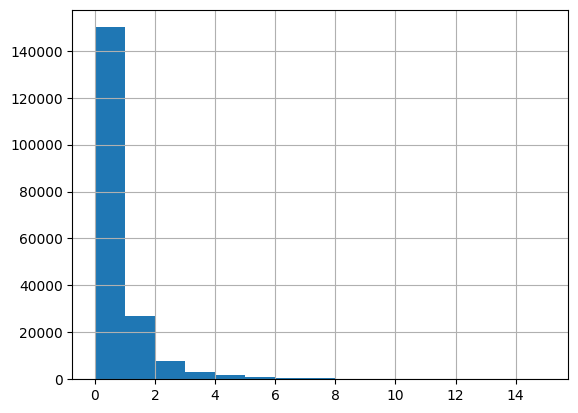

In [7]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())
print('Max of ships : ',unique_img_ids['ships'].max())
print('Avg of ships : ',unique_img_ids['ships'].mean())

## 2. Make dataset

### 2.1 Model Parameters

In [8]:
BATCH_SIZE = 32

# downsampling in preprocessing
IMG_SCALING = (3, 3)

# number of validation images to use
VALID_IMG_COUNT = 900

# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 10
MAX_TRAIN_EPOCHS = 99

### 2.2 Undersample Empty Images

In the cell below, we undersample groups by 4000 instances so each group will have a maximum of 4000 examples. After resampling, the dataset will be more balanced and more resistant to overfitting. Also, volume of data is highly reduced which will speed up our training process.

19778 masks


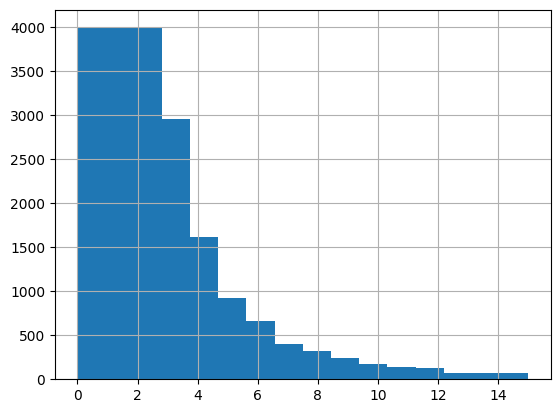

In [9]:
SAMPLES_PER_GROUP = 4000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

### 2.3 Split train & validation set

Using skit-learn built-in function our dataset is splitted into training and validation sets (80/20).

In [10]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df,
                 test_size = 0.2,
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

44212 training masks
11059 validation masks


### 2.4 Image generator

make_image_gen function is used to generate batches of images. If IMG_SCALING is defined, this function also scales image by factor:

---
    if IMG_SCALING = (3,3) then 768x768 image will be 256x256

In [11]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            try:
                rgb_path = os.path.join(TRAIN_DIR, c_img_id)
                c_img = imread(rgb_path)
                c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
                if IMG_SCALING is not None:
                    # scaling image by factor
                    c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                    c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
                out_rgb += [c_img]
                out_mask += [c_mask]
                if len(out_rgb)>=batch_size:
                    # dividing set of pixels by 255 is used to normalize data (so that values will be beetween 0 and 1)
                    yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0).astype(np.float32)
                    out_rgb, out_mask=[], []
            except:
                pass

In [12]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (32, 256, 256, 3) 0.0 1.0
y (32, 256, 256, 1) 0.0 1.0


### 2.5 Make validatation set

In [13]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

Exception ignored in: <generator object make_image_gen at 0x7d923f5b7680>
Traceback (most recent call last):
  File "<ipython-input-13-a407ca58fada>", line 1, in <cell line: 1>
RuntimeError: generator ignored GeneratorExit


(900, 256, 256, 3) (900, 256, 256, 1)


### 2.6 Data Augmentation

Data aumentaion is used to increase diversity and reduce chance of overfitting. Next filters are applied:
- Rotation by 45 degrees
- Width and height shift
- Shear
- Zoom between 90% and 125%
- Horizontal and vertical flip


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dg_args = dict(
                  rotation_range = 45,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'reflect',
                  data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)


def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))

    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(in_x,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)

        yield next(g_x), next(g_y)

In [15]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (32, 256, 256, 3) float32 0.0 1.0
y (32, 256, 256, 1) float32 0.0 1.0


## 3. Modeling

### 3.1 Base Model

In [17]:
from tensorflow.keras import models, layers

# Build U-Net model
def unet(pretrained_weights = None, input_size = (256, 256, 3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    seg_model = models.Model(inputs=[inputs], outputs=[d])

    seg_model.summary()
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return seg_model

In [18]:
seg_model = unet()
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

### 3.2 Loss function

For this task, Focal Loss will be used as it's a popular choice for segmentation problems. Dice coefficient will be used as metric for the model.

In [19]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):

    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return focal_loss

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

### 3.3 Callbacks setting

Amongst callbacks are ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau.
- ModelCheckpoint will save model weights every epoch
- ReduceLROnPlateau will reduce the learning rate when a metric has stopped improving
- EarlyStopping will stop training when a monitored metric has stopped improving

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
weight_path="fullres_model & weights/{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2,
                                   patience=3,
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef",
                      mode="max",
                      patience=15)
callbacks_list = [checkpoint, early, reduceLROnPlat]

### 3.4 Training

Start training with all prepared parameters.

In [23]:
def fit():
    seg_model.compile(optimizer=Adam(1e-3), loss = FocalLoss, metrics=[dice_coef])

    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [seg_model.fit(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1)]
    return loss_history

loss_history = fit()

Epoch 1/99
10/10 [==============================] - ETA: 0s - loss: 0.0388 - dice_coef: 0.0090
Epoch 1: saving model to fullres_model & weights/seg_model_weights.best.hdf5
10/10 [==============================] - 44s 2s/step - loss: 0.0388 - dice_coef: 0.0090 - val_loss: 0.0170 - val_dice_coef: 0.0075 - lr: 0.0010
Epoch 2/99
10/10 [==============================] - ETA: 0s - loss: 0.0097 - dice_coef: 0.0082
Epoch 2: saving model to fullres_model & weights/seg_model_weights.best.hdf5
10/10 [==============================] - 10s 1s/step - loss: 0.0097 - dice_coef: 0.0082 - val_loss: 0.0118 - val_dice_coef: 0.0131 - lr: 0.0010
Epoch 3/99
10/10 [==============================] - ETA: 0s - loss: 0.0084 - dice_coef: 0.0150
Epoch 3: saving model to fullres_model & weights/seg_model_weights.best.hdf5
10/10 [==============================] - 14s 2s/step - loss: 0.0084 - dice_coef: 0.0150 - val_loss: 0.0117 - val_dice_coef: 0.0169 - lr: 0.0010
Epoch 4/99
10/10 [==============================] - 

## 4. Testing

### 4.1 Full-Res model
If IMG_SCALING is defined, UpSampling layer is added to the model with respected factor of scaling.

In [26]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model

fullres_model.save('fullres_model & weights/fullres_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 4.2 Prediction function
Prediction generation function that takes image path, model and outputs representive mask.

In [28]:
import cv2
import tensorflow as tf

def gen_pred(test_dir, img, model):
    rgb_path = os.path.join(TEST_DIR,img)
    img = cv2.imread(rgb_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred, axis=0)
    return cv2.imread(rgb_path), pred

### 4.3 Run the test data

In [36]:
fullres_model = tf.keras.models.load_model('fullres_model & weights/fullres_model.h5')

1/1 [==============================] - 0s 32ms/step


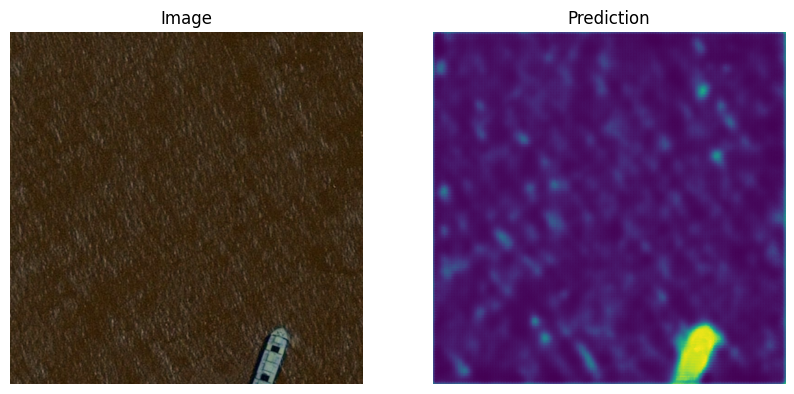

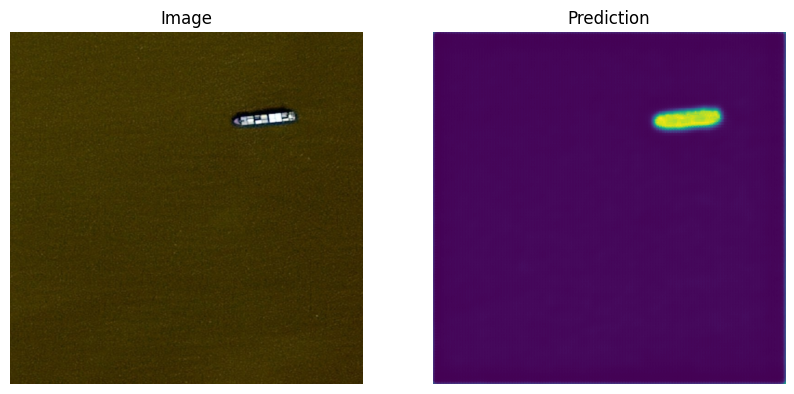

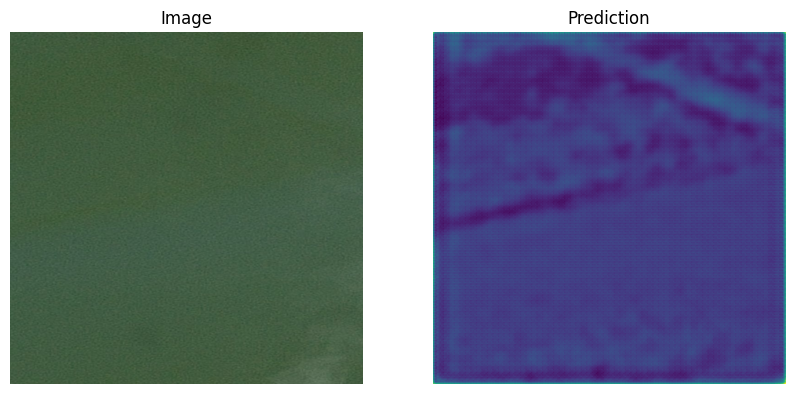

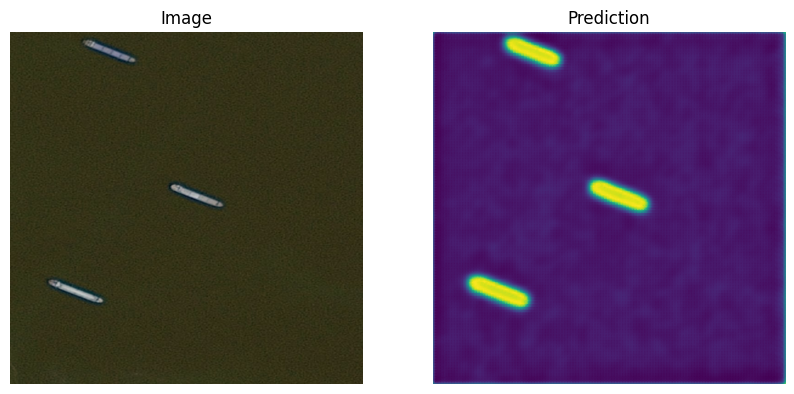

In [37]:
from matplotlib import pyplot as plt
test_imgs = ['002a943bf.jpg', '00c3db267.jpg', '004751507.jpg', '00dc34840.jpg']
%matplotlib inline

rows = 1
columns = 2
for i in range(len(test_imgs)):
    img, pred = gen_pred(TEST_DIR, test_imgs[i], fullres_model)
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(pred, interpolation=None)
    plt.axis('off')
    plt.title("Prediction")